In [148]:
# load libraries
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation


In [149]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '1096.SUB12877_lipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 

sample_dictionary = {'s1':'WT',
                     's2':'G2',
                     's3':'WT',
                     's4':'G2',
                     's5':'G2+choline'}

lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'darkblue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

In [150]:
# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT', 'G2')

stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)
print(stats.shape)

stats.head()

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


(432, 11)


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,name,grp,class,carbons,unsaturations,unsat_grp,cat
Cer(d15:0_26:2)-H_47.3,-1.833421,0.097373,-0.612545,0.209547,Cer(d15:0_26:2)-H_47.3,Sphingolipids,Cer,41,2,PUFA,other
Cer(d17:1_16:0)-H_42.85,-0.659965,0.524282,-0.242076,0.605588,Cer(d17:1_16:0)-H_42.85,Sphingolipids,Cer,33,1,MUFA,other
Cer(d18:0_16:0)+H_35.41,0.864029,0.412678,0.256591,0.497981,Cer(d18:0_16:0)+H_35.41,Sphingolipids,Cer,34,0,SFA,other
Cer(d18:0_18:0)+H_44.03,3.136402,0.017029,2.109618,0.060799,Cer(d18:0_18:0)+H_44.03,Sphingolipids,Cer,36,0,SFA,other
Cer(d18:0_18:0)-H_45.32,2.865600,0.020442,0.817624,0.069533,Cer(d18:0_18:0)-H_45.32,Sphingolipids,Cer,36,0,SFA,other


In [155]:
x = stats[stats['class'] == 'PC']
x[(x['fdr_corrected_p_value'] < 0.05) & (x['log2_fold_change'] < -1)].shape

(10, 11)

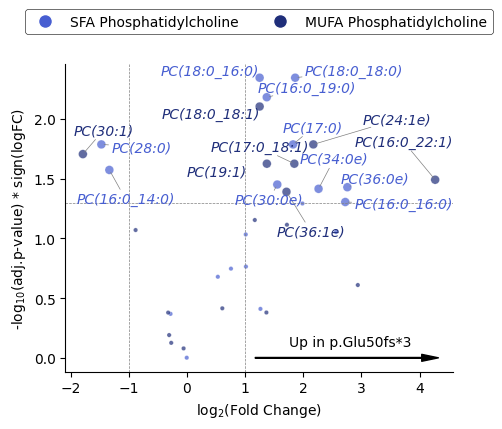

In [50]:
subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

#plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             #arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
#plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('../../../paper/main_plots/G2_PC_volcano_sat.png', dpi=300, bbox_inches='tight')



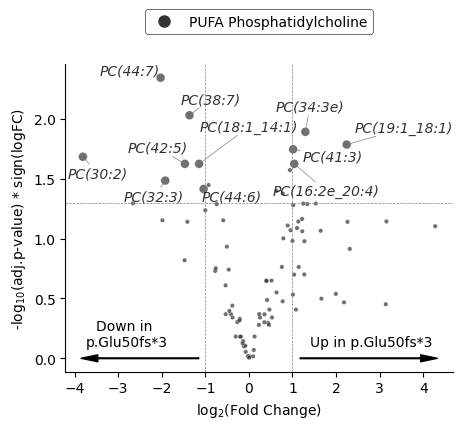

In [51]:
subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=5, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in \np.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('../../../paper/main_plots/G2_PC_volcano_unsat.png', dpi=300, bbox_inches='tight')



/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


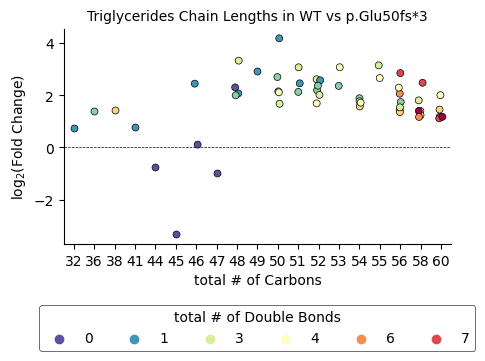

In [144]:
temp = stats[stats['class']=='TG'].copy()
temp['score'] = np.sign(temp['log2_fold_change']) * -np.log10(temp['fdr_corrected_p_value'])
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/tg_carbons.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


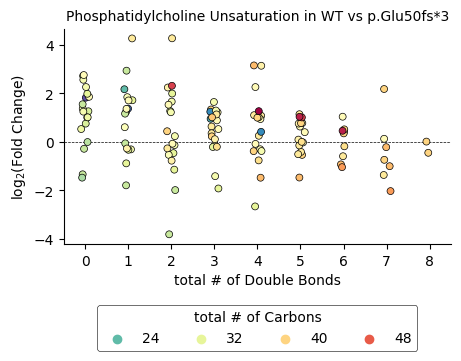

In [145]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/pc_unsat.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


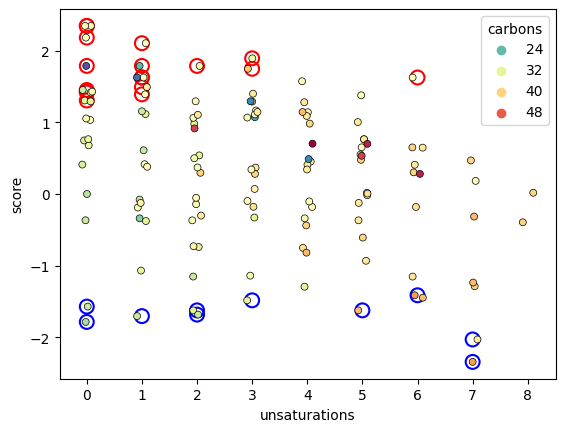

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Base stripplot
sp = sns.stripplot(data=temp, x='unsaturations', y='score', jitter=0.1, alpha=1, 
                   hue='carbons', palette='Spectral_r', edgecolor='black', linewidth=0.5)

# Overlay for points labeled 'up'
up = temp[temp['cat'] == 'up']
plt.scatter(x=up['unsaturations'], y=up['score'], facecolors='none', 
            edgecolors='red', linewidths=1.5, s=100)  # s controls marker size

# Overlay for points labeled 'down'
down = temp[temp['cat'] == 'down']
plt.scatter(x=down['unsaturations'], y=down['score'], facecolors='none', 
            edgecolors='blue', linewidths=1.5, s=100)

plt.show()


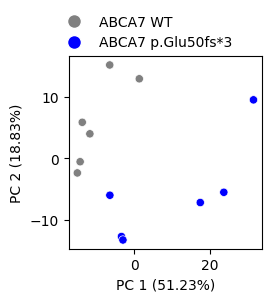

In [69]:
#Plot PCA
subset = areas.loc[:,areas_columns!='G2+choline'].copy()
names_subset = areas_columns[areas_columns!='G2+choline'].copy()
sample_palette = {'WT':'grey', 'G2':'blue'}
plot_pca(subset, names_subset, sample_palette, draw_median=False)

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
    Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Glu50fs*3')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)

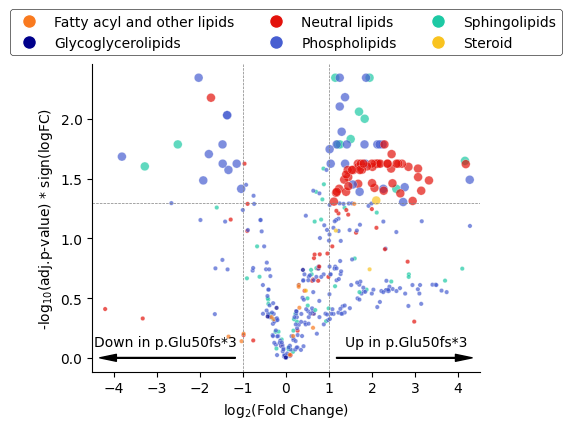

In [70]:
# plot volcano by major class
plot_volcano('fdr_corrected_p_value', 'name', 'grp', 'log2_fold_change',stats, lipid_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True, label_top_genes=False)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = np.unique(stats['grp'])[[x!='Neutral glycerolipid' for x in np.unique(stats['grp'])]]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=lipid_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('../../../paper/main_plots/iN_lipids_overview.png', dpi=300, bbox_inches='tight')



In [156]:
# get # of perturbed lipids per subclass

subclass_dict = dict(zip(key['Key'], key['subclass']))
grouped = stats.groupby('class')['cat'].value_counts().unstack(fill_value=0)

# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)

# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) + grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']

# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[['up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total', 'empty': ''}
)

# subset table to only include classes with more than 0 total
table_df.sort_values(by='Total', ascending=False, inplace=True)
table_df = table_df.loc[table_df['Total']>0].copy()

# add subclass
table_df['Subclass'] = [subclass_dict[x] for x in table_df.index]

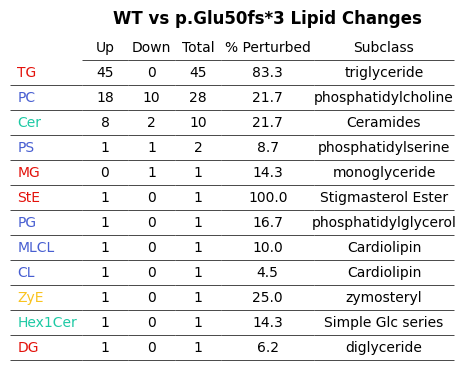

In [157]:
# plot the table 

table_palette = dict(zip(table_df.index, [lipid_palette[dictionary[x]] for x in table_df.index]))

fig, ax = plt.subplots(figsize=(3,2))
ax.axis('off')  # Hide the main axes

tbl = ax.table(cellText=table_df.values,
               rowLabels=table_df.index,
               colLabels=table_df.columns,
               cellLoc='center',
               loc='center', colWidths=[0.2, 0.2, 0.2, 0.4, 0.6])

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Color the row labels according to the palette.
# Matplotlib stores row labels in cells with (row, col) where col == -1.
for (row, col), cell in tbl.get_celld().items():
    if col == 0 and row > 0:  # row>0: skip header row label cell
        lipid_class = table_df.index[row-1]  # row labels start at row 1 in the table cells
        cell.set_facecolor(table_palette.get(lipid_class, 'blue'))

for key, cell in tbl.get_celld().items():
    
        cell.set_edgecolor('white')

for (row, col), cell in tbl.get_celld().items():
    if row > 0:  # for all cells in data rows
        # Show only the bottom edge:
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
    else:
        # For header row, you can keep the default (or set a full box if desired)
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)

    if col == -1 and row > 0:  # skip header label cell if present
        lipid_class = table_df.index[row-1]  # adjust index for header offset
        cell.get_text().set_color(table_palette.get(lipid_class, 'black'))
plt.title('WT vs p.Glu50fs*3 Lipid Changes', fontweight="bold", pad=70)
plt.savefig('../../../paper/main_plots/lipids_table.png', dpi=300, bbox_inches='tight')


In [147]:
import scipy.stats as STAT
#sf(k, M, n, N, loc=0)

def get_hypergeom_p_value(total_species, total_perturbed, total_subclass_size, subclass_perturbed):
    M = total_species              # Population size
    n = total_perturbed            # Total number of successes in the population
    N = total_subclass_size        # Number of draws
    x = subclass_perturbed         # Observed successes in the sample
    p_value = STAT.hypergeom.sf(x-1, M, n, N)
    return p_value

sfa_mufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

sfa_mufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC') & (stats['cat']=='down')].shape[0])

print('SFA/MUFA up p-value: ', sfa_mufa_up_pval)
print('SFA/MUFA down p-value: ', sfa_mufa_down_pval)


sfa_mufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

sfa_mufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']=='SFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='SFA')&(stats['class']=='PC') & (stats['cat']=='down')].shape[0])

print('SFA up p-value: ', sfa_mufa_up_pval)
print('SFA down p-value: ', sfa_mufa_down_pval)

pufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

pufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='PC') & (stats['cat']=='down')].shape[0])

print('PUFA up p-value: ', pufa_up_pval)
print('PUFA down p-value: ', pufa_down_pval)


SFA/MUFA up p-value:  0.0026646585371137635
SFA/MUFA down p-value:  0.10902047494433438
SFA up p-value:  0.0026646585371137635
SFA down p-value:  0.12170193193116274
PUFA up p-value:  0.9999976320204942
PUFA down p-value:  0.014846079872583181


In [140]:
import scipy.stats as STAT
#sf(k, M, n, N, loc=0)

def get_hypergeom_p_value(total_species, total_perturbed, total_subclass_size, subclass_perturbed):
    M = total_species              # Population size
    n = total_perturbed            # Total number of successes in the population
    N = total_subclass_size        # Number of draws
    x = subclass_perturbed         # Observed successes in the sample
    p_value = STAT.hypergeom.sf(x-1, M, n, N)
    return p_value

sfa_mufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='Cer')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='Cer') & (stats['cat']=='up')].shape[0])

sfa_mufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['down'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='Cer')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='Cer') & (stats['cat']=='down')].shape[0])

print('SFA/MUFA up p-value: ', sfa_mufa_up_pval)
print('SFA/MUFA down p-value: ', sfa_mufa_down_pval)

pufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='Cer')].shape[0], 
                      stats[(stats['unsat_grp']=='PUFA')&(stats['class']=='Cer') & (stats['cat']=='up')].shape[0])

pufa_down_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['class']=='Cer')].shape[0], 
                      stats[(stats['class']=='Cer') & (stats['cat']=='up')].shape[0])

print('PUFA up p-value: ', pufa_up_pval)
print('PUFA down p-value: ', pufa_down_pval)


SFA/MUFA up p-value:  0.58279316429038
SFA/MUFA down p-value:  0.6770661767545872
PUFA up p-value:  0.721272617625573
PUFA down p-value:  0.6320711041692477


#### Look at the two differentiation batches separately in terms of unsaturation of PCs

In [ ]:

###Based on this: emphasis should be on the unsaturated PCs being up 

In [ ]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '1096.SUB12877_lipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 

sample_dictionary = {'s1':'WT',
                     's2':'G2',
                     's3':'WT2',
                     's4':'G22',
                     's5':'G2+choline'}


In [ ]:
##Diff Batch 1
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT', 'G2')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)



In [ ]:
##Diff Batch 2
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT2', 'G22')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)



## Plotting some additional metrics below

In [ ]:
plt.figure(figsize=(5,2))
plot_class_counts(stats)

In [ ]:
plot_carbon_distributions(stats)

In [ ]:
# by group stats
groups = [x.split('(')[0] for x in areas.index]
by_grp = areas.groupby(groups).sum()
by_grp_stats = return_stats(by_grp, areas_columns, 'WT', 'G2')

by_grp_stats['score'] = -1*np.log10(by_grp_stats['p_value']) * np.sign(by_grp_stats['log2_fold_change'])
by_grp_stats.sort_values(by='p_value')

In [ ]:
# classify fatty acids in TGs
selected_rows_TG = areas[np.array(groups)=='TG']

carbon_counts_classified = np.array([classify_fatty_acid_length(np.round(count_carbons(x)/3)) for x in selected_rows_TG.index])

by_grp = selected_rows_TG.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, areas_columns, 'WT', 'G2')
by_grp_stats



In [ ]:
np.unique(carbon_counts_classified, return_counts=True)

In [ ]:
# classify fatty acids in PCs
selected_rows_PC = areas[np.array(groups)=='PC']

carbon_counts_classified = np.array([classify_unsaturation(count_unsaturations(x)) for x in selected_rows_PC.index])

by_grp = selected_rows_PC.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, areas_columns, 'WT', 'G2')
by_grp_stats



In [ ]:
np.unique(carbon_counts_classified, return_counts=True)